# Climpyrical National Building Code
## Analysis of Gradient Boosting Regression Using 15 Spatial Orthogonal Basis Functions
Nic Annau, Pacific Climate Impacts Consortium

## Load Climpyrical and Other Dependencies

In [96]:
!pip install ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import pickle

%load_ext autoreload
%autoreload 2

Processing /home/nannau/temp/climpyrical/climpyrical_master/climpyrical
  Stored in directory: /tmp/pip-ephem-wheel-cache-zmp9cz4h/wheels/8b/bf/2e/6a26fa0f442da9fda3291448d1e2863d0ff36814cba03aac77
Successfully built climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
You should consider upgrading via the 'pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Ensemble from File

In [97]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
ds = read_data(PATH, dv)

## Load Shapefile and Generate Mask

In [98]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)

mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values, canada)

## Take Anomally of Design Value Ensembles

In [99]:
ens_mean = ds[dv].values.mean(axis=0)
ens_mean.shape

(130, 155)

## Apply any additional masking
If the model has any NaN values left over that the mask did not catch, find them, and add them to the mask using `logical_and`. Reshape arrays and mask to all work with the same mask. 

In [100]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

In [101]:
d_grid = pickle.load(open("values.p", "rb"))

# Load the station data from file
Add new columns of converted longitude and latitude into rotated pole coordinate

In [102]:
from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor


frac = 0.1

df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)
df['rlon'], df['rlat'] = transform_coords(df['lon'].values, df['lat'].values)


rlon_ens, rlat_ens = flatten_coords(ds.rlon.values, ds.rlat.values, ds)

dist_to_closest_station = pairwise_distances_argmin_min(
            np.array(list(zip(rlon_ens, rlat_ens))),
            np.array(list(zip(df.rlon, df.rlat))),
            metric='euclidean'
        )[1]


df_non_stations = pd.DataFrame({
                    'rlon': rlon[final_mask], 
                    'rlat': rlat[final_mask], 
                    'mean': ens_mean[final_mask],
                    'distance_weights': dist_to_closest_station[final_mask.flatten()]**5
})

img_dist_arr = np.reshape(dist_to_closest_station, ens_mean.shape)
img_dist_arr[~final_mask] = np.nan


df_non_stations_weight = df_non_stations.sample(frac=frac, weights='distance_weights')
df_to_add = pd.DataFrame({
                    'rlon': df_non_stations_weight.rlon, 
                    'rlat': df_non_stations_weight.rlat, 
                    'RL50 (kPa)': df_non_stations_weight['mean'],
                    'label': 'model'})
df['label'] = 'stations'
# df = pd.concat([df, df_to_add], sort=False)

rlon_i, rlat_i = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# Add nearest rlon and rlat locations in grid to stations
df['rlon_nearest'], df['rlat_nearest'] = ds.rlon.values[rlon_i], ds.rlat.values[rlat_i]
df['rlon_nearest_index'], df['rlat_nearest_index'] = rlon_i, rlat_i

# Zip together a tuple of grid indices
df['nearest_grid'] = list(zip(rlon_i, rlat_i))
df['count'] = df['nearest_grid']

# Group together stations falling in same grid cell and take mean
station_dv = 'RL50 (kPa)'
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                    station_dv: 'mean',
                                    'lat':'min',
                                    'lon':'min',
                                    'rlat':'min',
                                    'rlon':'min',
                                    'rlat_nearest':'min',
                                    'rlon_nearest':'min',
                                    'rlon_nearest_index':'mean',
                                    'rlat_nearest_index':'mean',
                                    'label': 'min',
                                    'count':'count'
                                })
# Remove stations with zero rainfall as advised
df0 = ndf

ndf = ndf[ndf['RL50 (kPa)'] != 0.0]



# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

mean_values_at_real_stations = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ens_mean, final_mask, ds)
bases = [find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ds[dv].values[i, :, :], final_mask, ds) for i in range(35)]
values = np.stack(bases)
print(values.shape, mean_values_at_real_stations.shape)
# values = np.concatenate((values, mean_values_at_real_stations.reshape(1, -1)), axis=0)
values = np.concatenate((values, ndf.rlon.values.reshape(1, -1)), axis=0)
values = np.concatenate((values, ndf.rlat.values.reshape(1, -1)), axis=0)


# values = np.delete(values, [0, 1, 2], axis=0)
# values=values[important_features]
X, Y = values.T, np.sqrt(ndf['RL50 (kPa)'].values)

p = {'learning_rate': 0.002857142857142857,
 'n_estimators': 2980,
 'max_depth': 6,
 'min_samples_leaf': 8,
 'min_samples_split': 8}

# model = ensemble.GradientBoostingRegressor(
#     **p
# )

model = KNeighborsRegressor(n_neighbors=5, weights='distance')
# model = RadiusNeighborsRegressor(radius=.50, weights='uniform')

print(X.shape
     )

model.fit(X, Y)
ndf['predict'] = model.predict(X)
stations = ndf[ndf.label == 'stations']

rmse = np.sqrt(mean_squared_error(
        ndf[ndf.label == 'stations']['RL50 (kPa)'], 
        stations['predict']**2
    )
)

rmse_mean_sample = np.sqrt(mean_squared_error(
        ndf['RL50 (kPa)'], 
        ndf['predict']**2
    )
)

# rmse_mean_and_stations
sx, sy = ndf[ndf.label == 'stations']['rlon_nearest_index'].values, ndf[ndf.label == 'stations']['rlat_nearest_index'].values
mean_values_at_real_stations = find_nearest_index_value(ds.rlon.values, ds.rlat.values, sx, sy, ens_mean, final_mask, ds)

rmse_mean_and_stations = np.sqrt(mean_squared_error(
        ndf[ndf.label == 'stations']['RL50 (kPa)'], 
        mean_values_at_real_stations
    )
)

rmse_mean_and_stations

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning:

36.222662646628834 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning:

32.64541886648805 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning:

31.345755932126362 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning:

29.59681105435813 is outside of array's domain between             -28.59999656677246 and 28.159999847

(35, 292) (292,)
(292, 37)


/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:114: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0.12467281056448695

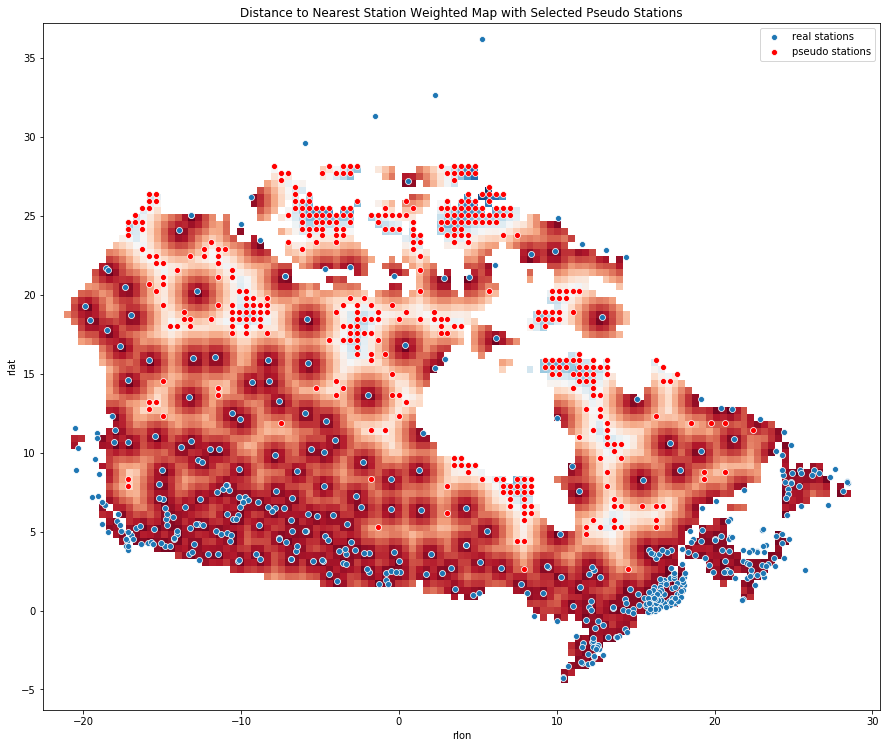

In [103]:
plt.figure(figsize=(15, 15))
# sns.scatterplot('rlon', 'rlat', hue='distance_weights', marker='s', s=50, palette='RdBu', data=df_non_stations)
sns.scatterplot('rlon', 'rlat',  marker='o', data=df, label='real stations')
sns.scatterplot('rlon', 'rlat', marker='o', color='red', data=df_non_stations_weight, label='pseudo stations')
plt.imshow(
    img_dist_arr, 
    cmap='RdBu', 
    origin='lower', 
    extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
    label='distance weighting'
)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.title("Distance to Nearest Station Weighted Map with Selected Pseudo Stations")
plt.legend()
plt.savefig("weighted_map")
plt.show()

## Regression Score

Model R2 score: 1.0
Model RMSE: 4.603234069431463e-17
Mean RMSE: 4.603234069431463e-17


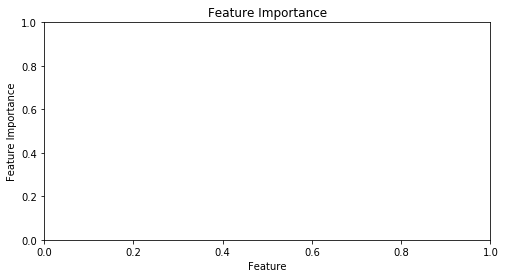

In [104]:
print("Model R2 score:", model.score(X, Y))

# rmse = np.sqrt(mean_squared_error(Y, model.predict(X)))
print("Model RMSE:", rmse)

# rmse_mean = np.sqrt(mean_squared_error(ndf['RL50 (kPa)'].values, mean_values))
print("Mean RMSE:", rmse_mean_sample)

# plots
plt.figure(figsize=(8, 4))
plt.title("Feature Importance")
# tstr = [str(t) for t in tuples]
# plt.bar(tstr, model.feature_importances_)
# plt.bar(range(model.feature_importances_.size), model.feature_importances_)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.show()

# important_features = model.feature_importances_ >= 0.03

## Reconstruct the entire field

In [105]:
# dc = d_grid[..., 0].flatten().copy()
dc = ds[dv].values[0, ...].flatten().copy()

# d_gridx = np.dstack([d_grid, rlat, rlon])

# d_gridx = d_grid
print(ds[dv].values.shape, ens_mean.shape)

d_gridx = np.moveaxis(ds[dv].values, 0, -1)#[..., important_features]
# d_gridx = np.dstack((d_gridx, ens_mean))
d_gridx = np.dstack((d_gridx, rlon))
d_gridx = np.dstack((d_gridx, rlat))

# d_gridx = np.delete(d_gridx, [0, 1, 2], axis=2)
d_gridx.shape, dc[final_mask.flatten()].shape, d_gridx.shape

(35, 130, 155) (130, 155)


((130, 155, 37), (4087,), (130, 155, 37))

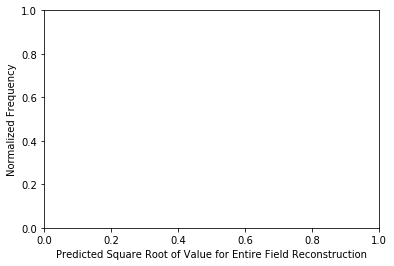

In [106]:
dc[final_mask.flatten()] = model.predict(d_gridx[final_mask])**2
# sns.distplot(model.predict(d_gridx[final_mask])**2)
plt.xlabel("Predicted Square Root of Value for Entire Field Reconstruction")
plt.ylabel("Normalized Frequency")
plt.savefig("/home/nannau/Pictures/recondist")
assert np.any(model.predict(d_gridx[final_mask]) < 0.0) == False

In [107]:
dc[~final_mask.flatten()] = np.nan
final = dc.reshape(d_gridx[..., 0].shape)
fff = final_mask
dcb = dc.copy()
dcb[final_mask.flatten()] = model.predict(d_gridx[final_mask]) <= 0.0
dcb = dcb.reshape(final_mask.shape)

assert np.allclose(dcb[final_mask], 0.0)

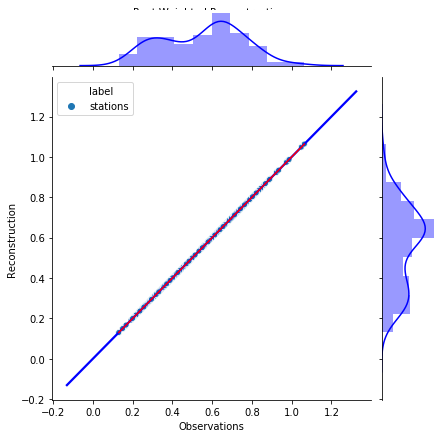

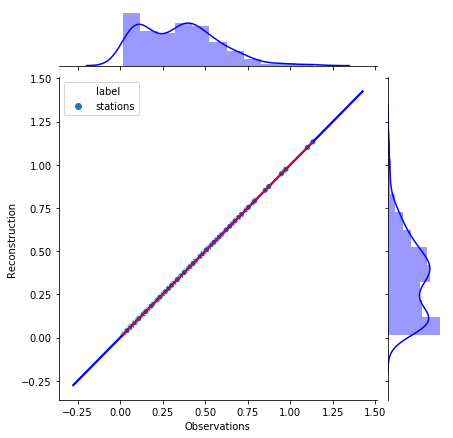

slope of plot 1.0 r2_val of plot 1.0


In [108]:
sns.jointplot(Y.flatten(), model.predict(X), kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y.flatten(), model.predict(X), hue=ndf.label, marker='o')
sns.lineplot(Y.flatten(), Y.flatten(), color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')
plt.savefig('recon_1:1')
plt.text(0.2, 1.7, "Root Weighted Reconstruction")
plt.show()

sns.jointplot(Y.flatten()**2, model.predict(X)**2, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y.flatten()**2, model.predict(X)**2, hue=ndf.label, marker='o')
sns.lineplot(Y.flatten()**2, Y.flatten()**2, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')
plt.text(0.2, 1.8, "Non-Weighted Reconstruction")
plt.savefig('recon_1:1')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(Y.flatten()**2, model.predict(X).flatten()**2)
print("slope of plot", slope, "r2_val of plot", r_value**2)

## Plot the final reconstructed field

## Change the colors to highlight contours

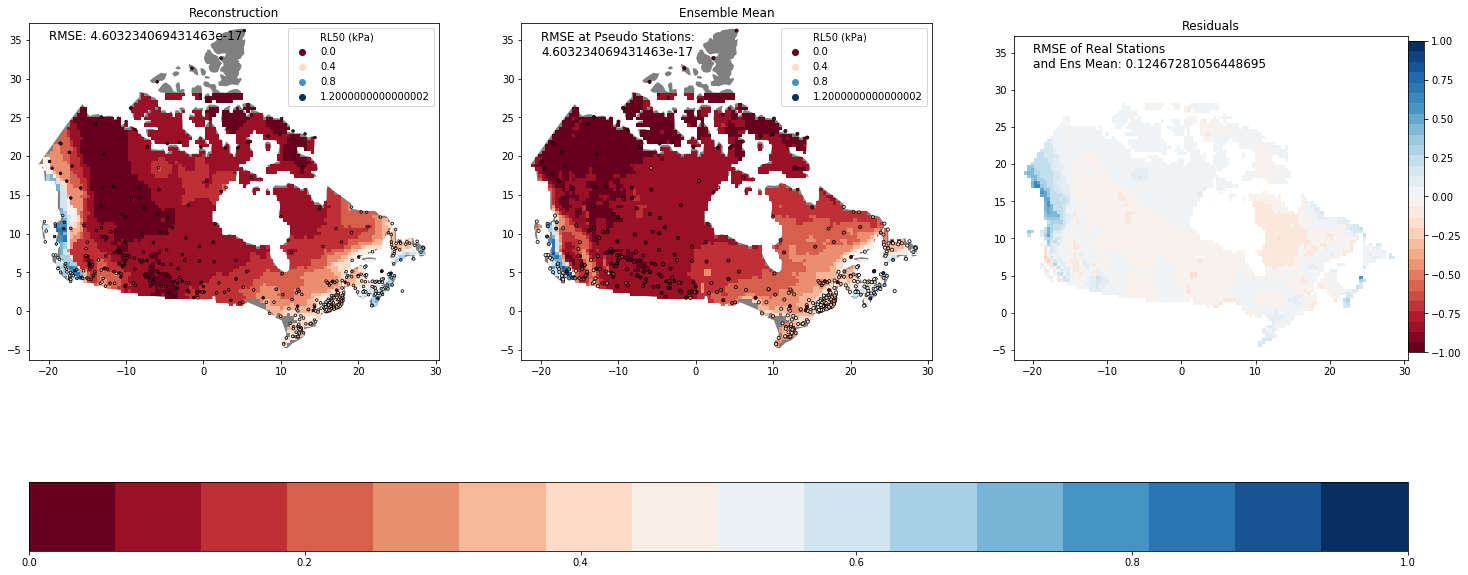

In [378]:
ens_mean_with_nan = ens_mean.copy()
ens_mean_with_nan[~final_mask] = np.nan
ens_mean_with_nan = ens_mean_with_nan.reshape(ens_mean.shape)

fig, ax = plt.subplots(1, 3, figsize=(25, 15))
vmin=0
vmax=1.
canada.plot(ax=ax[0], color='gray', zorder=0)
sns.scatterplot(df[df.label=='stations'].rlon.values, df[df.label=='stations'].rlat.values, hue=df[df.label=='stations']['RL50 (kPa)'], ax=ax[0], palette='RdBu', s=7, edgecolor='black', hue_norm=(vmin, vmax))

canada.plot(ax=ax[1], color='gray', zorder=0)
sns.scatterplot(df[df.label=='stations'].rlon.values, df[df.label=='stations'].rlat.values, hue=df[df.label=='stations']['RL50 (kPa)'], ax=ax[1], palette='RdBu', s=10, edgecolor='black', hue_norm=(vmin, vmax))

img = ax[0].imshow(
        final,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax
)

img1 = ax[1].imshow(
        ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax
)

img2 = ax[2].imshow(
        final-ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 30), vmin=-1., vmax=1.
)

ax[0].set_title("Reconstruction")
ax[0].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[0].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[0].text(-20, 35, "RMSE: {}".format(rmse), fontsize=12, zorder=1)

ax[1].set_title("Ensemble Mean")
ax[1].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[1].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[1].text(-20, 33, "RMSE at Pseudo Stations: \n{}".format(rmse_mean_sample), fontsize=12)

ax[2].set_title("Residuals")
ax[2].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[2].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[2].text(-20, 33, "RMSE of Real Stations \nand Ens Mean: {}".format(rmse_mean_and_stations), fontsize=12)
plt.colorbar(img2, ax=ax[2], orientation='vertical', fraction=0.038, pad=0.001)

fig.colorbar(img1, ax=ax, orientation='horizontal')
plt.savefig('synthetic_composite.pdf')
plt.savefig('synthetic_composite.png')

## Plot the ensemble mean

## Upscale/Interpolate the final reconstructed field 10 fold

In [110]:
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator

rlon_ens, rlat_ens = flatten_coords(ds.rlon.values, ds.rlat.values, ds)
irlat, irlon = np.linspace(rlat.min(), rlat.max(), rlat.shape[0]*10), np.linspace(rlon.min(), rlon.max(), rlon.shape[1]*10)

x, y = flatten_coords(irlon, irlat, ds)
points = np.array(list(zip(x, y)))
np.array(list(zip(rlon_ens, rlat_ens))), d_grid[final_mask], final[final_mask].flatten()

iff = LinearNDInterpolator(list(zip(rlon_ens, rlat_ens)), final.flatten())
ifinal = iff(points)

In [111]:
# reshape into a grid
ifinal = ifinal.reshape(irlat.shape[0], irlon.shape[0])

## Plot final interpolated field

In [118]:
from io import BytesIO
import base64
def fig_to_uri(in_fig, close_all=True, **save_args):
    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    in_fig.savefig(out_img, format='png', **save_args)
    if close_all:
        in_fig.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    return "data:image/png;base64,{}".format(encoded)


fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
vmin, vmax = 0., 1.1
img = ax.imshow(ifinal, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax, orientation='horizontal',shrink=0.8)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions.pdf')
plt.savefig('reconstructions.png')

out_uri = fig_to_uri(fig)

data = dict(
    source = out_uri,
    xref= "x",
    yref= "y",
    sizing= "stretch",
    opacity= 0.5,
    layer= "below"
)

# unique_url = py.plot_mpl(mpl_fig, filename="my first plotly plot")


In [263]:
import matplotlib
from matplotlib import cm
import numpy as np

magma_cmap = matplotlib.cm.get_cmap('RdBu', 16)
norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

magma_rgb = []

for i in range(0, 255):
    k = matplotlib.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
    magma_rgb.append(k)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 16)
magma

[[0.0, 'rgb(103, 0, 31)'],
 [0.06666666666666667, 'rgb(153, 16, 39)'],
 [0.13333333333333333, 'rgb(190, 48, 54)'],
 [0.2, 'rgb(214, 96, 77)'],
 [0.26666666666666666, 'rgb(234, 141, 112)'],
 [0.3333333333333333, 'rgb(247, 182, 152)'],
 [0.4, 'rgb(253, 219, 199)'],
 [0.4666666666666667, 'rgb(249, 237, 231)'],
 [0.5333333333333333, 'rgb(234, 241, 244)'],
 [0.6, 'rgb(209, 229, 240)'],
 [0.6666666666666666, 'rgb(167, 207, 228)'],
 [0.7333333333333333, 'rgb(119, 180, 213)'],
 [0.8, 'rgb(67, 147, 195)'],
 [0.8666666666666667, 'rgb(44, 117, 179)'],
 [0.9333333333333333, 'rgb(23, 84, 147)'],
 [1.0, 'rgb(5, 48, 97)']]

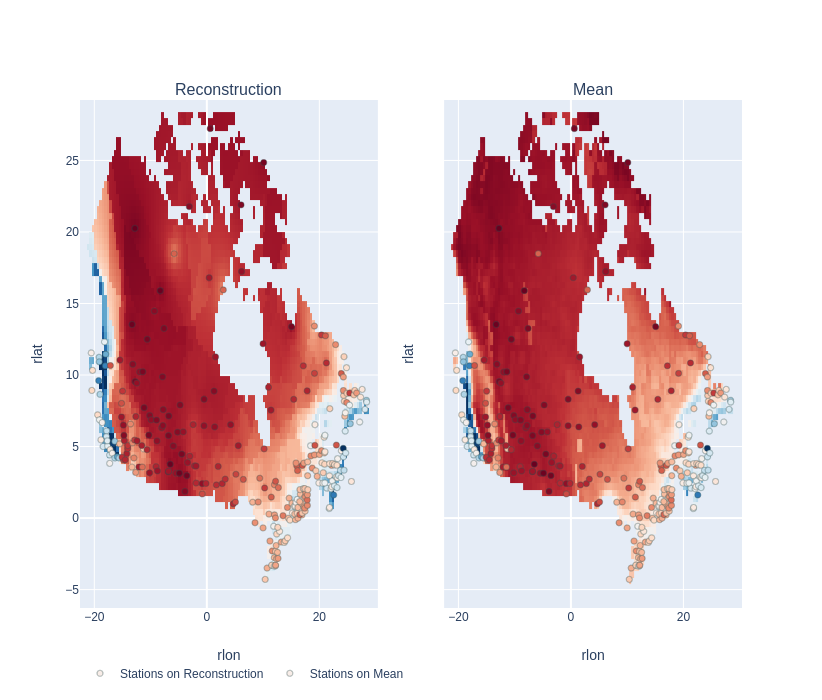

In [417]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly import colors as clr

fig = make_subplots(rows=1, cols=2, subplot_titles=("Reconstruction", "Mean"), 
                    shared_xaxes=True, 
                    shared_yaxes=True)

fig.add_trace(
            go.Heatmap(
                z=final,
                x=ds.rlon.values,
                y=ds.rlat.values,
                hoverongaps = False,
                colorscale=magma,
                zmin=0,
                zmax=0.8,
                zsmooth=False,
                showscale=False,
                colorbar=dict(tick0=0, dtick=1/16.),
                hovertemplate =
                "<b>Reconstructed Value: %{z} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>" ,
                name="Reconstruction",                
            ),
)

fig.add_trace(
            go.Heatmap(
                z=ens_mean_with_nan,
                x=ds.rlon.values,
                y=ds.rlat.values,
                hoverongaps = False,
                colorscale=magma,
                zmin=0,
                zmax=0.8,
                zsmooth=False,
                colorbar=dict(tick0=0, dtick=1/16.),
                showscale=False,
                hovertemplate =
                "<b>Mean: %{z} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>" ,
                name="Mean",
            ),
        row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=ndf.rlon.values, 
        y=ndf.rlat.values,
        mode='markers',
        marker=dict(
            color=ndf['RL50 (kPa)'], 
            colorscale=magma,
            line=dict(width=0.35,
            color='DarkSlateGrey')
        ),
        text = ndf['RL50 (kPa)'].values,
        hoverinfo = 'text',
        hovertemplate =
                "<b>Station Value: %{text} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>",
    name="Stations on Reconstruction"
    ),
    row=1,col=1
)

fig.add_trace(
    go.Scatter(
        x=ndf.rlon.values, 
        y=ndf.rlat.values,
        mode='markers',
        marker=dict(
            color=ndf['RL50 (kPa)'], 
            colorscale=magma,
            line=dict(width=0.35,
            color='DarkSlateGrey')
        ),
        text = ndf['RL50 (kPa)'].values,
        hoverinfo = 'text',
        hovertemplate =
                "<b>Station Value: %{text} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>",
    name="Stations on Mean"
    ),
    row=1,col=2
)
#     legend=)

fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=1, col=1, mirror=True)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=1, col=1, mirror=True)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=1, col=2, mirror=True)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=1, col=2, mirror=True)
# fig.add_trace(
#     go.Scatter(
#         x=Y.flatten()**2, 
#         y=model.predict(X)**2,
#         mode='markers',
#         marker=dict(
#             color='blue',
#             symbol='x',
#             line=dict(width=0.35,
#             color='DarkSlateGrey')
#         ),
#         text = model.predict(X)**2,
#         hoverinfo = 'text',
#         hovertemplate =
#                 "Station Value: %{x}<br>" +
#                 "Reconstructed Value: %{y}<br>",
#     ),
#     row=1, col=2
# )

# fig.update_yaxes(title="Reconstruction", row=1, col=2)
# fig.update_xaxes(title="Stations", row=1, col=2)


# # Add dropdown
# fig.update_layout(
#     updatemenus=[
#         go.layout.Updatemenu(
#             type = "buttons",
#             direction = "left",
#             buttons=list([
#                 dict(
#                     args=["type", "scatter", "heatmap"],
#                     label="With Stations",
#                     method="restyle",
#                 ),
#                 dict(
#                     args=["type", "heatmap"],
#                     label="No Stations",
#                     method="restyle",
#                 ),
                
#             ]),
#             pad={"r": 10, "t": 10},
#             showactive=True,
# #             x=0.11,
#             xanchor="left",
# #             y=1.1,
#             yanchor="top"
#         ),
#     ]
# )

# # Add annotation
# fig.update_layout(
#     annotations=[
#         go.layout.Annotation(text="Trace type:", showarrow=False,
#                              x=0, y=1.08, yref="paper", align="left")
#     ]
# )


fig.update_layout(
    width=1200, 
    height=700,
    showlegend=True,
    legend_orientation="h",
)
plotly.offline.plot(fig, filename='name.html')
fig.show()

In [343]:

fig = go.Figure(
    data=[go.Surface(z=final)],
)
# fig.update_layout(title='RL50 (kPa) Reconstruction', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))

fig.update_layout(scene = dict(
#         xaxis = dict(range=[ds.rlon.values.min(),ds.rlon.values.max()],),
#                      yaxis = dict(range=[ds.rlat.values.min(),ds.rlat.values.max()],),
                     zaxis = dict(range=[0,1],),),
                     width=700,
                     height=700,
                     margin=dict(r=20, l=10, b=10, t=10),
                 title="<br>RL50 Reconstruction for Canada"),
plotly.offline.plot(fig, filename='name.html')

# fig.update_zaxes(title='Reconstructed RL50 (kPa)')

'name.html'

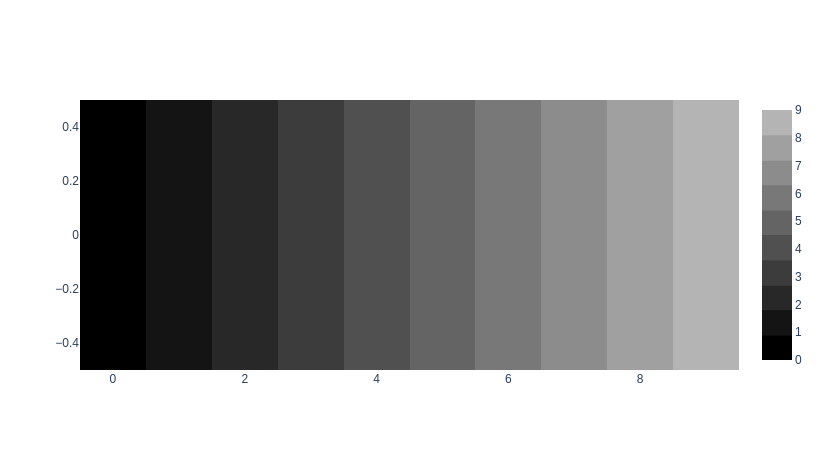

In [269]:
fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
    colorscale=[
        # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
        [0, "rgb(0, 0, 0)"],
        [0.1, "rgb(0, 0, 0)"],

        # Let values between 10-20% of the min and max of z
        # have color rgb(20, 20, 20)
        [0.1, "rgb(20, 20, 20)"],
        [0.2, "rgb(20, 20, 20)"],

        # Values between 20-30% of the min and max of z
        # have color rgb(40, 40, 40)
        [0.2, "rgb(40, 40, 40)"],
        [0.3, "rgb(40, 40, 40)"],

        [0.3, "rgb(60, 60, 60)"],
        [0.4, "rgb(60, 60, 60)"],

        [0.4, "rgb(80, 80, 80)"],
        [0.5, "rgb(80, 80, 80)"],

        [0.5, "rgb(100, 100, 100)"],
        [0.6, "rgb(100, 100, 100)"],

        [0.6, "rgb(120, 120, 120)"],
        [0.7, "rgb(120, 120, 120)"],

        [0.7, "rgb(140, 140, 140)"],
        [0.8, "rgb(140, 140, 140)"],

        [0.8, "rgb(160, 160, 160)"],
        [0.9, "rgb(160, 160, 160)"],

        [0.9, "rgb(180, 180, 180)"],
        [1.0, "rgb(180, 180, 180)"]
    ],
    colorbar=dict(
        tick0=0,
        dtick=1
    )
))

fig.show()